## Imports

In [40]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
import shap
import seaborn as sns
import matplotlib.pyplot as plt

## Load / De-Nullify the Baseline Data

In [27]:
data = pd.read_csv("../Josh/EnergyAndAvgWeather.csv")
# these are either null, or unnecessary (Unamed)
data = data.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'Unnamed: 0', 'weather_id'])
# drop all datapoints that have all their values as null
data = data.dropna(how='all')
# drop datapoints that have less than 20 NON-null values
data = data.dropna(thresh=20)
data = data.fillna(data.mean())
assert sum(data.isnull().sum()) == 0

## Prelim EDA

<AxesSubplot:>

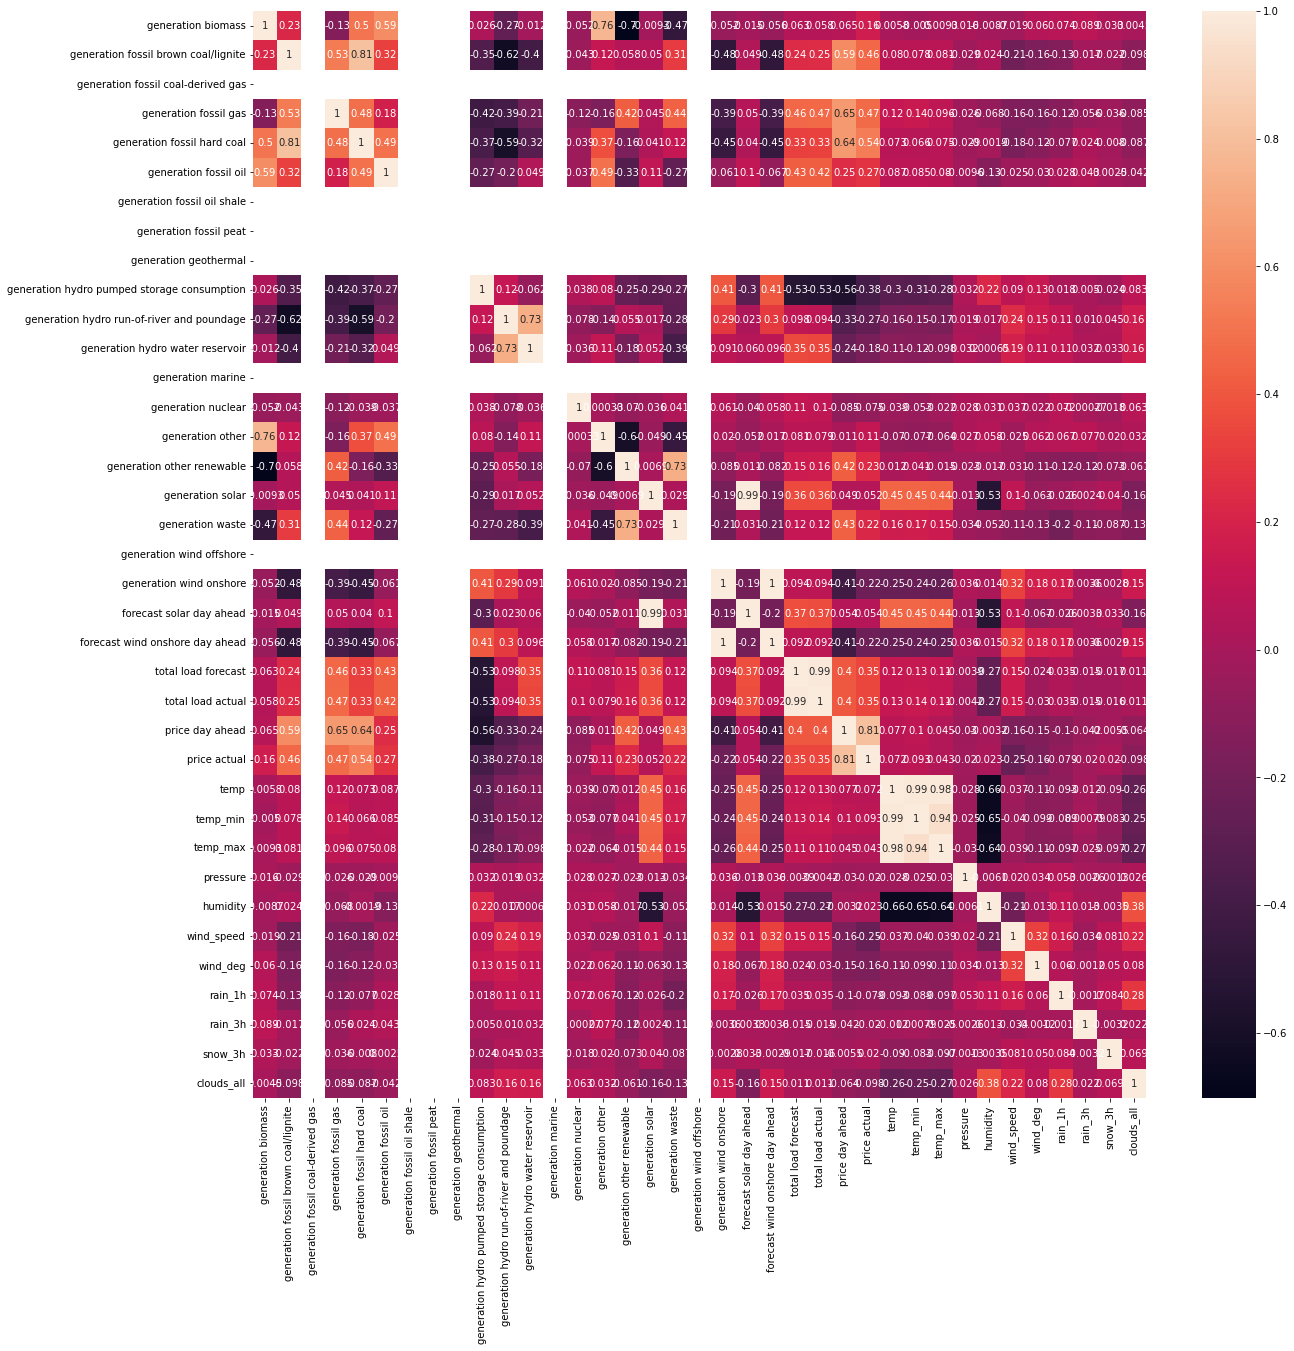

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True,fmt='.2g')

## Data

In [91]:
predictor_columns = ['forecast solar day ahead',
       'forecast wind onshore day ahead', 'temp',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
predictor_columns_gen = ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore']
target_price = 'price actual'
target_solar = 'generation solar'

## Split Data

In [69]:
training, testing = train_test_split(data, test_size=0.3)

## Scaling Data Values

In [70]:
mms = MinMaxScaler()
min_tar_price_train = training[target_price].min()
max_tar_price_train = training[target_price].max()
min_tar_price_test = testing[target_price].min()
max_tar_price_test = testing[target_price].max()

min_tar_solar_train = training[target_solar].min()
max_tar_solar_train = training[target_solar].max()
min_tar_solar_test = testing[target_solar].min()
max_tar_solar_test = testing[target_solar].max()
scaled_training = pd.DataFrame(mms.fit_transform(training), columns=data.columns)
scaled_testing = pd.DataFrame(mms.fit_transform(testing), columns=data.columns)

In [71]:
def return_to_unscaled(scaled_val, min_val, max_val):
    return scaled_val * (max_val - min_val) + min_val

## Reduce to Predictor Columns

In [72]:
X_train, y_train = scaled_training[predictor_columns], scaled_training[target_solar]
X_test, y_test = scaled_testing[predictor_columns], scaled_testing[target_solar]

## Model 1: XGBoost Regressor - Predict Generation Solar

In [73]:
model_xgb = xgboost.XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
y_test_pred = model_xgb.predict(X_test)

In [75]:
mean_squared_error(y_test,y_test_pred)

0.0005522046903072425

In [76]:
unsc_val = [return_to_unscaled(i, min_tar_solar_test, max_tar_solar_test) for i in y_test]

In [77]:
unsc_pred = [return_to_unscaled(i, min_tar_solar_test, max_tar_solar_test) for i in y_test_pred]

In [78]:
mean_squared_error(unsc_val, unsc_pred)

17175.18327609315

In [79]:
diff = np.abs(np.array(unsc_val) - np.array(unsc_pred))

In [80]:
for i in range(0, 100, 5):
    p = np.percentile(diff, i)
    print(f"{i}th Percentile: {p}",)

0th Percentile: 0.011957132816405647
5th Percentile: 5.544703542292052
10th Percentile: 11.486909674406206
15th Percentile: 18.26666786968699
20th Percentile: 24.714216803908336
25th Percentile: 31.83434056006378
30th Percentile: 38.76983262848104
35th Percentile: 46.461998412190084
40th Percentile: 53.36119895577426
45th Percentile: 61.62281954504547
50th Percentile: 70.50890912413581
55th Percentile: 79.02760630369188
60th Percentile: 88.15200765103094
65th Percentile: 99.07125240609035
70th Percentile: 110.51971575006843
75th Percentile: 124.15913930982364
80th Percentile: 142.28082958340647
85th Percentile: 164.00736035853586
90th Percentile: 195.20198953747715
95th Percentile: 256.33982756778585


## Model 1: Interpret

In [81]:
exp = shap.TreeExplainer(model_xgb, feature_dependence='independent', data=X_test)
shap_values = exp.shap_values(X_test.iloc[np.argmin(diff)])
shap.initjs()
display(shap.force_plot(exp.expected_value, shap_values, X_test.iloc[np.argmin(diff)]))

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


In [82]:
exp = shap.TreeExplainer(model_xgb, feature_dependence='independent', data=X_test)
shap_values = exp.shap_values(X_test.iloc[np.argmax(diff)])
shap.initjs()
display(shap.force_plot(exp.expected_value, shap_values, X_test.iloc[np.argmax(diff)]))
# From an initial inspection, it seems that the more incorrect a prediction is, the less context it got from other varirables

## Model 2: Predicting Price ACtual

In [113]:
X_train, y_train = scaled_training[predictor_columns], scaled_training[target_price]
X_test, y_test = scaled_testing[predictor_columns], scaled_testing[target_price]

In [114]:
model_xgb = xgboost.XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
y_test_pred = model_xgb.predict(X_test)

In [116]:
mean_squared_error(y_test, y_test_pred)

0.01896049798158901

In [118]:
unsc_val = [return_to_unscaled(i, min_tar_price_test, max_tar_price_test) for i in y_test]
unsc_pred = [return_to_unscaled(i, min_tar_price_test, max_tar_price_test) for i in y_test_pred]

In [119]:
mean_squared_error(unsc_val, unsc_pred)

119.57596175058077

In [125]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [127]:
r2_score(y_test, y_test_pred)

0.16708860596367248

In [126]:
r2_score(unsc_val, unsc_pred)

0.16708860596367248

In [124]:
cross_val_score(model_xgb, X_test, y_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


array([0.39746286, 0.41810743, 0.39895795, 0.43087756, 0.424908  ])

## Model 2: Interpret Model

In [112]:
y_test_pred

array([0.5488989 , 0.4718342 , 0.42512184, ..., 0.5869629 , 0.45356432,
       0.48117262], dtype=float32)

In [89]:
exp = shap.TreeExplainer(model_xgb, feature_dependence='independent', data=X_test)
shap_values = exp.shap_values(X_test.iloc[1])
shap.initjs()
display(shap.force_plot(exp.expected_value, shap_values, X_test.iloc[1]))

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


## Model 3: What affect do different generations of different kinds of energies have on price actual?

In [92]:
X_train, y_train = scaled_training[predictor_columns_gen], scaled_training[target_price]
X_test, y_test = scaled_testing[predictor_columns_gen], scaled_testing[target_price]

In [93]:
model_xgb = xgboost.XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
y_test_pred = model_xgb.predict(X_test)

In [95]:
mean_squared_error(y_test, y_test_pred)

0.005158587326052648

In [103]:
for index in np.argsort(y_test)[-5:]:
    exp = shap.TreeExplainer(model_xgb, feature_dependence='independent', data=X_test)
    shap_values = exp.shap_values(X_test.iloc[index])
    shap.initjs()
    display(shap.force_plot(exp.expected_value, shap_values, X_test.iloc[index]))

In [107]:
for index in np.argsort(y_test)[:5]:
    exp = shap.TreeExplainer(model_xgb, feature_dependence='independent', data=X_test)
    shap_values = exp.shap_values(X_test.iloc[index])
    shap.initjs()
    display(shap.force_plot(exp.expected_value, shap_values, X_test.iloc[index]))